# Get Data from Single Velocity
From all of the Al data, get only that from `v = 1.0`. Also, mark the initial transient

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import pickle as pkl
import pandas as pd
import numpy as np
import os

## Load in the Entire Dataset
This includes data from all velocities and all trajectories

In [2]:
data = pd.read_pickle(os.path.join('..', 'training_data.pkl.gz'))
print('Loaded %d entries'%len(data))

Loaded 82569 entries


Add the starting frame

In [3]:
start_frame = pkl.load(open(os.path.join('..', 'al_starting_frame.pkl'), 'rb'))

## Get the `v = 1.0` subset
Nice and easy query

In [4]:
data = data[np.isclose(data['velocity'].apply(np.linalg.norm), 1.0, atol=1e-3)]
print('Downselected to %d entries'%len(data))

Downselected to 35400 entries


In [5]:
traj_names = set(data['directory'])
print('Number of trajectories:', len(traj_names))
assert len(traj_names) == 6

Number of trajectories: 6


## Mark the Initial Transients
The forces in the first part of the simulation are too high because the system is still reacting to the introduction of the projectile.

In [6]:
data['initial'] = False

In [7]:
traj_names

{'datasets/256_Al/Dv1.0',
 'datasets/Al_256_channel/Dv1.0',
 'datasets/Al_256_new/Dmin_v1.0',
 'datasets/Al_256_new/Dmod_v1.0',
 'datasets/Al_256_new/Doptimal_v1.0',
 'datasets/Al_256_new/Drnddir2_v1.0'}

### For the Random Trajectory
One of the two trajectories we have is along a random path

In [8]:
random_traj = 'datasets/256_Al/Dv1.0'

In [9]:
random_traj

'datasets/256_Al/Dv1.0'

In [10]:
random_data = data[data['directory'] == random_traj].copy()
print('Number of points:', len(random_data))

Number of points: 9800


Plot the force as a function of displacement for the beginning part of the trajectory

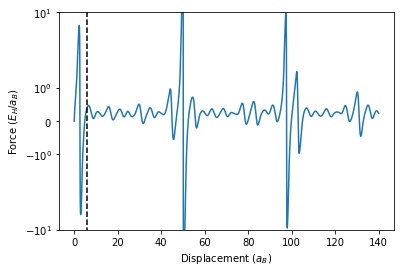

In [11]:
fig, ax = plt.subplots()

ax.plot(random_data['displacement'], random_data['force'])
ax.plot([6,6], [-100,100], 'k--')

ax.set_yscale('symlog')

#ax.set_xlim(0, 15)
ax.set_ylim(-10, 10)

ax.set_xlabel('Displacement ($a_B$)')
ax.set_ylabel('Force ($E_H/a_B$)')

In [12]:
sum(random_data['displacement'] < 6)

421

*Finding*: The choice of 6 $a_B$ by Schleife *et al* seems reasonable

In [13]:
random_data['initial'] = random_data['displacement'] < 6

In [14]:
print('Total number of points:', np.logical_not(random_data['initial']).sum())

Total number of points: 9379


## Channel Trajectory
The other trajectory is along a channel in the FCC structure

In [15]:
channel_traj = [x for x in traj_names if 'channel' in x][0]

In [16]:
channel_traj

'datasets/Al_256_channel/Dv1.0'

In [17]:
channel_data = data[data['directory'] == channel_traj].copy()

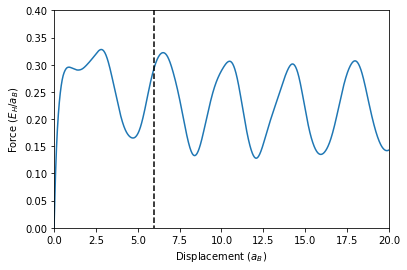

In [18]:
fig, ax = plt.subplots()

ax.plot(channel_data['displacement'], channel_data['force'])
ax.plot([6,6], [-100,100], 'k--')

ax.set_xlim(0, 20)
ax.set_ylim(0, 0.4)

ax.set_xlabel('Displacement ($a_B$)')
ax.set_ylabel('Force ($E_H/a_B$)')

*Finding*: The 6 $a_B$ cutoff also seems like a good choce here as well

In [19]:
channel_data['initial'] = channel_data.eval('displacement < 6')

In [20]:
channel_data['initial'].value_counts()

False    1579
True      421
Name: initial, dtype: int64

Also determine the range to average over, between the 1st and 3rd lattice spacings

In [21]:
lat_spacing = start_frame.cell[0,0] / 4

In [22]:
channel_data['average_range'] = False

In [23]:
channel_data['average_range'] = channel_data.eval('displacement >= {}  and displacement <= {}'.format(lat_spacing, 3 * lat_spacing))

In [24]:
print('Total number of points:', np.logical_not(channel_data['initial']).sum())

Total number of points: 1579


## Load in the New Data
It is stored in a few different subdirectories, we want to load them in separately and index them by name. For each dataset, we'll use the a cutoff for 'initial' data of 6 $a_B$

In [25]:
new_dirs = traj_names.difference({'datasets/256_Al/Dv1.0', 'datasets/Al_256_channel/Dv1.0'})

In [26]:
new_data = dict((os.path.basename(d), group) for d, group in 
                data[data['directory'].apply(lambda x: x in new_dirs)].groupby('directory'))
assert len(new_data) == 4

Plot the new data

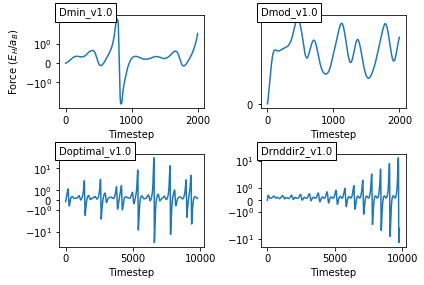

In [27]:
fig, axs = plt.subplots(2, 2)
axs = axs.flatten()

for i, (ax, (d, subset)) in enumerate(zip(axs, new_data.items())):
    ax.plot(subset['timestep'], subset['force'])
    ax.set_yscale('symlog')
    
    # Make a label for the figure
    ax.text(0, 1, d, bbox={'facecolor': 'w', 'edgecolor': 'k'},
           transform=ax.transAxes)
    
    # Make axes labels
    ax.set_xlabel('Timestep')
    if i == 0:
        ax.set_ylabel('Force ($E_H / a_B$)')
            
fig.tight_layout()

Label the cutoff

In [28]:
for subset in new_data.values():
    subset['initial'] = subset['displacement'] < 6

## Save the Results to Disk
For easy use later

In [29]:
if not os.path.isdir('data'):
    os.mkdir('data')

In [30]:
channel_data.to_pickle(os.path.join('data', 'channel_data.pkl.gz'))

In [31]:
random_data.to_pickle(os.path.join('data', 'random_data.pkl.gz'))

In [32]:
with open(os.path.join('data', 'new_data.pkl'), 'wb') as fp:
    pkl.dump(new_data, fp)